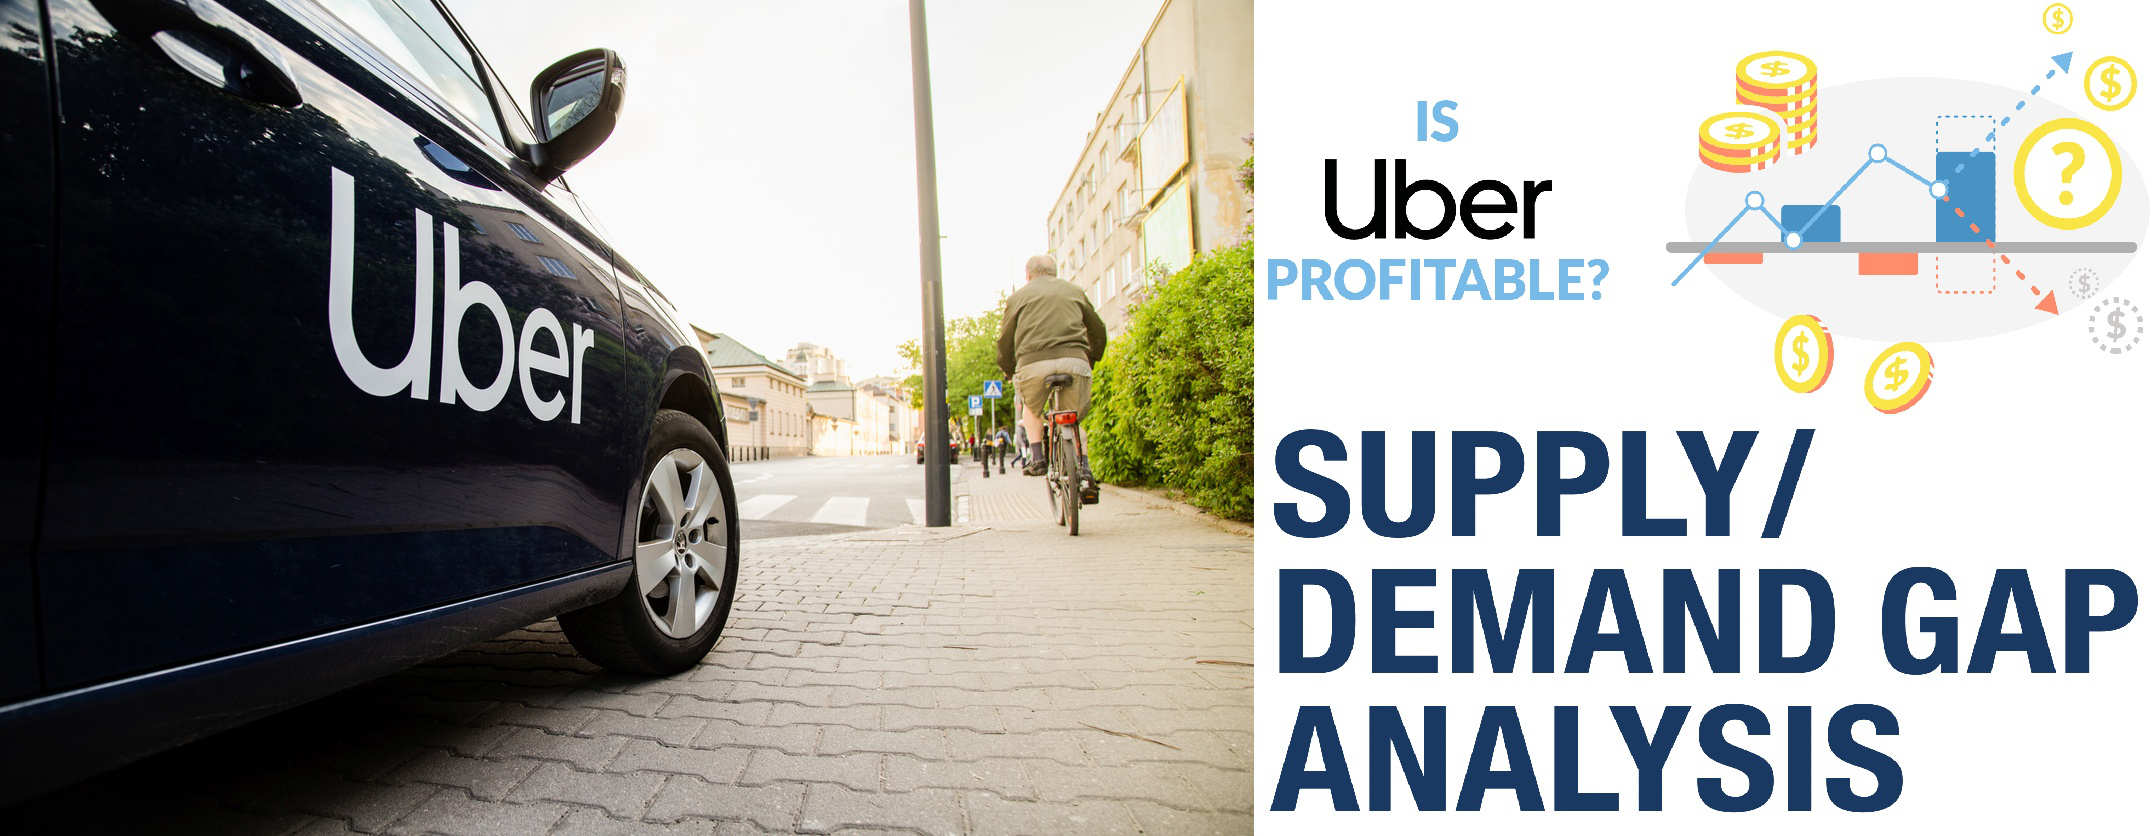

# Uber Supply Demand Gap Analysis For Bengaluru,India
## Data of year 2016
Demonstrated by **Biswarup Das**

**Dataset Link:** https://www.kaggle.com/datasets/anupammajhi/uber-request-data?resource=download

## Major issues impacting Uber's business are:

* **Cancellation of rides going towards the airport were higher than regular trips**
* **Trips to and from an airport resulted in high consumption of fuel and time. Hence, a trip back to the city without a rider is not economically bebeficial for the driver.**
* **Due to high variance in flight arrivals (higher during evening, late night hours) the driver idle time is higher in morning. As a result, no cars are available during peak ight hours because working hours ends for majority drivers at night.**

## Exploratory Data Analysis (EDA) is done on the raw dataset from Kaggle then to draw some useful insights I used Power BI in later analysis  .**

**As a part of EDA I have followed below steps:**

* **Data Extraction    : Load the raw dataset and inspect different features.**
* **Data Cleaning      : Correcting date time formats & filling in missing values.**
* **Feature Engineering: Determine new features.**

## Data Description:
* **Request id:** A unique identifier of the request.
* **Pickup point:** The point from which the request was made.
* **Driver id:** The unique identification number of the driver.
* **Status:** The final status of the trip, that can be either completed, cancelled by the driver or no cars available.
* **Request timestamp:** The date and time at which the customer made the trip request.    
* **Drop timestamp:** The drop-off date and time, in case the trip was completed.    

## Data Extraction
**Importing usefull libraries**

In [1]:
import numpy as np
import pandas as pd

In [2]:
uber = pd.read_csv("Uber Request Data.csv")
uber.head(5)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [3]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


I can see that two coluns, i.e. **Request timestamp** & **Drop timestamp** are not consistent datetime format

## Data Cleaning 


In [4]:
sum(uber.duplicated(subset="Request id"))==0 # checking for duplicate rows

True

In [5]:
uber.shape # checking dimension of the dataframe 

(6745, 6)

In [6]:
uber.isnull().sum() # checking null values

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

In [9]:
# Calculating null value percentage for each column
pd.DataFrame(round(100*(uber.isnull().sum()/len(uber.index)),2))

,0
Request id,0.00
Pickup point,0.00
Driver id,39.29
Status,0.00
Request timestamp,0.00
Drop timestamp,58.03


**I can see that 'Driver id' & 'Drop timestamp' have considerable null values, these entries are probably the rides where trip were never assigned to a driver & it was not completed (status- no car available).**

In [10]:
pd.DataFrame(uber.isnull().sum(axis=1)) # row wise null value count

,0
0,0
1,0
2,0
3,0
4,0
...,...
6740,2
6741,2
6742,2
6743,2


**Converting format of 'Request timestamp' & 'Drop timestamp' to datetime format**

In [12]:
uber['Request timestamp'] = pd.to_datetime(uber['Request timestamp'])
uber['Drop timestamp'] = pd.to_datetime(uber['Drop timestamp'])

In [14]:
uber['Request timestamp'].max()

Timestamp('2016-12-07 23:54:00')

In [16]:
uber.info() # rechecking Dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Request id         6745 non-null   int64         
 1   Pickup point       6745 non-null   object        
 2   Driver id          4095 non-null   float64       
 3   Status             6745 non-null   object        
 4   Request timestamp  6745 non-null   datetime64[ns]
 5   Drop timestamp     2831 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 316.3+ KB


## Feature Engineering

**Adding new columns, 'Request Hours' & 'Drop Hours' to the dataset from column 'Request timestamp' & 'Drop timestamp' resp.**

In [17]:
uber['Request Hours'] = uber['Request timestamp'].apply(lambda x:x.hour)
uber['Drop Hours'] = uber['Drop timestamp'].apply(lambda x:x.hour)

In [18]:
uber.head(5)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request Hours,Drop Hours
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,11,13.0
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,17,18.0
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,9,9.0
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,21,22.0
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8,9.0


**Adding new column 'Request Time Slot' to each request according to the time range defined in a function below:**
* **[Ohours-8hours]  - Early Morning Hours**
* **[8hours-12hours] - Peak Morning Hours**
* **[12hours-17hours]- Noon Hours**
* **[17hours-21hours]- Evening Hours**
* **[21hours<]       - Night Hours**

In [21]:
def determine_time_slot(x):
    if (x>=0 and x<8):
        return "Early morning hours" #12am - 7am
    elif (x>=8 and x<12):
        return "Peak morning hours"  #8am - 11am
    elif (x>=12 and x<17):
        return "Noon hours"          #12pm - 4pm
    elif (x>=17 and x<21):
        return "Evening hours"       #5pm - 8pm
    elif (x>=21):
        return "Night hours"         #9pm onwards
uber['Request Time Slot'] = uber['Request Hours'].apply(determine_time_slot)    

In [22]:
uber.head(5)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request Hours,Drop Hours,Request Time Slot
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,11,13.0,Peak morning hours
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,17,18.0,Evening hours
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,9,9.0,Peak morning hours
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,21,22.0,Night hours
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,8,9.0,Peak morning hours


## Exporting the Updated Uber Dataset

In [23]:
uber.to_csv('uber_EDA_update.csv')

# Now it's time to move into Power BI for further Analysis...